In [ ]:
!pip install tensorflow
!pip install opencv-python


STUDENT NAME : ADEKUNLE OLOMOLA
STUDENT ID : 100887419
COURSE : AIDI 2000
ASSIGNMENT 2

In [ ]:
from zipfile import ZipFile

Dataset = '/Dataset.zip'
with ZipFile(Dataset, 'r') as zip:
  zip.extractall()
  print('extracted data')


extracted data


In [ ]:
import cv2
import os
import numpy as np

DATA_DIR = '/content/Dataset'  # The path to the dataset
CATEGORIES = ['with_mask', 'without_mask']

training_data = []
IMG_SIZE = 64

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                face = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([face, class_num])
            except Exception as e:
                pass

create_training_data()


In [ ]:
import random
from sklearn.model_selection import train_test_split

random.shuffle(training_data)

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

# define data augmentation
trainAug = ImageDataGenerator(rotation_range=20,
                              zoom_range=0.15,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.15,
                              horizontal_flip=True,
                              fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# compile our model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

history = model.fit(
    trainAug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BATCH_SIZE,
    epochs=EPOCHS)



Epoch 1/10
276/276 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9299

276/276 [==============================] - 183s 597ms/step - loss: 0.2074 - accuracy: 0.9299 - val_loss: 14.5515 - val_accuracy: 0.6252
Epoch 2/10
276/276 [==============================] - 165s 599ms/step - loss: 0.2028 - accuracy: 0.9418
Epoch 3/10
276/276 [==============================] - 155s 560ms/step - loss: 0.1151 - accuracy: 0.9648
Epoch 4/10
276/276 [==============================] - 151s 548ms/step - loss: 0.0691 - accuracy: 0.9799
Epoch 5/10
276/276 [==============================] - 119s 432ms/step - loss: 0.0545 - accuracy: 0.9855
Epoch 6/10
276/276 [==============================] - 111s 404ms/step - loss: 0.0443 - accuracy: 0.9858
Epoch 7/10
276/276 [==============================] - 110s 398ms/step - loss: 0.0488 - accuracy: 0.9849
Epoch 8/10
276/276 [==============================] - 109s 395ms/step - loss: 0.0884 - accuracy: 0.9731
Epoch 9/10
276/276 [==============================] - 109s 394ms/step - loss: 0.0600 - accuracy: 0.9819
Epoch 10/10
276/276 [===========

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(accuracy))



Test Loss: 0.5136411190032959
Test Accuracy: 0.9769126176834106


In [ ]:
model.save('mask_detector.model', save_format="h5")


In [ ]:
def prepare(filepath):
    img_array = cv2.imread(filepath)
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    img_array = img_array / 255.0  # normalize pixel values to [0, 1]
    return img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

img_path = '/content/Dataset/without_mask/102.jpg'

prediction = model.predict([prepare(img_path)])

# Since we are using sigmoid activation function in the output layer
# for binary classification, we can directly compare the prediction with 0.5
if prediction > 0.5:
    print("Mask")
else:
    print("No Mask")


1/1 [==============================] - 0s 25ms/step
No Mask


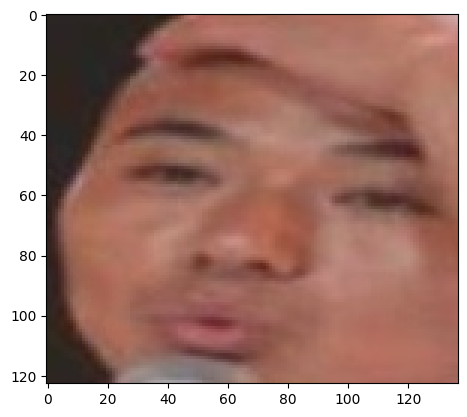

In [ ]:
import matplotlib.pyplot as plt

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()